In [24]:
# ============================================================
# 1️⃣ Load Solana Dataset
# ============================================================
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
data_file = '/content/drive/MyDrive/AdvMLAT3/datas/solana_2years_daily.csv'

# Load the dataset
sol_df = pd.read_csv(data_file)

# Convert timestamp columns
sol_df['timestamp'] = pd.to_datetime(sol_df['timestamp'], errors='coerce')
sol_df = sol_df.sort_values('timestamp').reset_index(drop=True)

print("="*70)
print("SOLANA DATA LOADED")
print("="*70)
print(f"Records: {len(sol_df)}")
print(f"Date range: {sol_df['timestamp'].min().date()} → {sol_df['timestamp'].max().date()}")
print(f"Columns: {list(sol_df.columns)}")

# Preview
display(sol_df.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SOLANA DATA LOADED
Records: 721
Date range: 2023-11-07 → 2025-10-27
Columns: ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp', 'daily_range', 'date']


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,daily_range,date
0,2023-11-07,2023-11-07,2023-11-07,2023-11-07,Solana,42.19,44.74,40.12,42.95,1.161821e+06,NaN,2023-11-07,4.62,2023-11-07
1,2023-11-08,2023-11-08,2023-11-08,2023-11-08,Solana,42.95,43.92,42.29,43.14,7.992401e+05,NaN,2023-11-08,1.63,2023-11-08
2,2023-11-09,2023-11-09,2023-11-09,2023-11-09,Solana,43.14,48.96,42.53,45.33,1.955370e+06,NaN,2023-11-09,6.43,2023-11-09
3,2023-11-10,2023-11-10,2023-11-10,2023-11-10,Solana,45.30,57.58,45.05,56.72,2.186259e+06,NaN,2023-11-10,12.53,2023-11-10
4,2023-11-11,2023-11-11,2023-11-11,2023-11-11,Solana,56.68,63.99,53.56,56.35,1.710170e+06,NaN,2023-11-11,10.43,2023-11-11


In [25]:
# ============================================================
# 2️⃣ Target Variable – Next Day’s HIGH Price
# ============================================================
sol_df['target_high_tomorrow'] = sol_df['high'].shift(-1)

print("\n✓ Target Variable Created: target_high_tomorrow")
display(sol_df[['timestamp', 'high', 'target_high_tomorrow']].head(5))
print(f"Valid targets: {sol_df['target_high_tomorrow'].notna().sum()}")
print(f"Missing (last rows): {sol_df['target_high_tomorrow'].isna().sum()}")



✓ Target Variable Created: target_high_tomorrow


,timestamp,high,target_high_tomorrow
0,2023-11-07,44.74,43.92
1,2023-11-08,43.92,48.96
2,2023-11-09,48.96,57.58
3,2023-11-10,57.58,63.99
4,2023-11-11,63.99,61.99


Valid targets: 720
Missing (last rows): 1


In [26]:
# ============================================================
# 3️⃣ Lag Features
# ============================================================
lag_days = [1, 2, 3, 5, 7, 14, 30]

for lag in lag_days:
    sol_df[f'high_prev_{lag}']  = sol_df['high'].shift(lag)
    sol_df[f'low_prev_{lag}']   = sol_df['low'].shift(lag)
    sol_df[f'close_prev_{lag}'] = sol_df['close'].shift(lag)
    sol_df[f'open_prev_{lag}']  = sol_df['open'].shift(lag)

print("\n✓ Lag Features Created")
print(f"  Total lag periods: {lag_days}")
sample_lag_cols = [col for col in sol_df.columns if 'prev' in col][:8]
display(sol_df[['timestamp', 'high'] + sample_lag_cols].head(5))


✓ Lag Features Created
  Total lag periods: [1, 2, 3, 5, 7, 14, 30]


,timestamp,high,high_prev_1,low_prev_1,close_prev_1,open_prev_1,high_prev_2,low_prev_2,close_prev_2,open_prev_2
0,2023-11-07,44.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-08,43.92,44.74,40.12,42.95,42.19,NaN,NaN,NaN,NaN
2,2023-11-09,48.96,43.92,42.29,43.14,42.95,44.74,40.12,42.95,42.19
3,2023-11-10,57.58,48.96,42.53,45.33,43.14,43.92,42.29,43.14,42.95
4,2023-11-11,63.99,57.58,45.05,56.72,45.30,48.96,42.53,45.33,43.14


In [27]:
# ============================================================
# 4️⃣ Rolling Statistics (Trends & Volatility)
# ============================================================
roll_windows = [7, 14, 30, 60, 90]

for window in roll_windows:
    # Simple and Exponential Moving Averages
    sol_df[f'sma_close_{window}'] = sol_df['close'].rolling(window).mean()
    sol_df[f'sma_high_{window}']  = sol_df['high'].rolling(window).mean()
    sol_df[f'ema_close_{window}'] = sol_df['close'].ewm(span=window, adjust=False).mean()
    # Rolling Standard Deviation
    sol_df[f'std_close_{window}'] = sol_df['close'].rolling(window).std()
    # Rolling Min / Max
    sol_df[f'low_min_{window}']  = sol_df['low'].rolling(window).min()
    sol_df[f'high_max_{window}'] = sol_df['high'].rolling(window).max()

print("\n✓ Rolling Statistics Added")
display(sol_df[['timestamp', 'close', 'sma_close_7', 'ema_close_7', 'std_close_7']].tail(5))




✓ Rolling Statistics Added


,timestamp,close,sma_close_7,ema_close_7,std_close_7
716,2025-10-23,191.40,186.372857,188.238361,4.053088
717,2025-10-24,193.58,188.024286,189.573770,4.329553
718,2025-10-25,193.89,188.917143,190.652828,4.850236
719,2025-10-26,200.02,190.644286,192.994621,6.358283
720,2025-10-27,202.64,192.490000,195.405966,7.764908


In [28]:
# ============================================================
# 5️⃣ Clean up and Save Processed Data
# ============================================================
processed_path = '/content/drive/MyDrive/AdvMLAT3/datas/solana_features_engineered.csv'
df.to_csv(processed_path, index=False)

print("\n" + "="*70)
print("✓ FEATURE ENGINEERING COMPLETE")
print("="*70)
print(f"Saved processed dataset to: {processed_path}")
print(f"Total columns after feature engineering: {len(df.columns)}")
print(f"Total records: {len(df)}")


✓ FEATURE ENGINEERING COMPLETE
Saved processed dataset to: /content/drive/MyDrive/AdvMLAT3/datas/solana_features_engineered.csv
Total columns after feature engineering: 84
Total records: 721


In [29]:
# ============================================================
# 5️⃣ Technical Indicators
# ============================================================
import numpy as np

print("="*70)
print("CALCULATING TECHNICAL INDICATORS")
print("="*70)

# ---------- RSI ----------
def rsi_indicator(price_series, lookback=14):
    delta = price_series.diff()
    gain = delta.clip(lower=0).rolling(lookback).mean()
    loss = (-delta.clip(upper=0)).rolling(lookback).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

sol_df['rsi_7']  = rsi_indicator(sol_df['close'], lookback=7)
sol_df['rsi_14'] = rsi_indicator(sol_df['close'], lookback=14)
sol_df['rsi_30'] = rsi_indicator(sol_df['close'], lookback=30)

print("✓ RSI Indicators: rsi_7, rsi_14, rsi_30")
display(sol_df[['timestamp', 'close', 'rsi_7', 'rsi_14', 'rsi_30']].tail(5))

# ---------- MACD ----------
def macd_indicator(price_series, short_win=12, long_win=26, signal_win=9):
    short_ema = price_series.ewm(span=short_win, adjust=False).mean()
    long_ema  = price_series.ewm(span=long_win, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_win, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

sol_df['macd_line'], sol_df['macd_signal'], sol_df['macd_hist'] = macd_indicator(sol_df['close'])

print("\n✓ MACD Indicators: macd_line, macd_signal, macd_hist")
display(sol_df[['timestamp', 'close', 'macd_line', 'macd_signal', 'macd_hist']].tail(5))

# ---------- Bollinger Bands ----------
def bollinger_bands(price_series, period=20, k=2):
    mid = price_series.rolling(period).mean()
    std = price_series.rolling(period).std()
    upper = mid + (k * std)
    lower = mid - (k * std)
    bandwidth = (upper - lower) / mid
    percent_b = (price_series - lower) / (upper - lower)
    return upper, lower, mid, bandwidth, percent_b

(sol_df['bb_upper'], sol_df['bb_lower'], sol_df['bb_mid'],
 sol_df['bb_bandwidth'], sol_df['bb_percent']) = bollinger_bands(sol_df['close'])

print("\n✓ Bollinger Bands Added: bb_upper, bb_lower, bb_mid, bb_bandwidth, bb_percent")
display(sol_df[['timestamp', 'close', 'bb_upper', 'bb_mid', 'bb_lower']].tail(5))

CALCULATING TECHNICAL INDICATORS
✓ RSI Indicators: rsi_7, rsi_14, rsi_30


,timestamp,close,rsi_7,rsi_14,rsi_30
716,2025-10-23,191.40,60.427296,38.571539,45.522114
717,2025-10-24,193.58,68.827362,52.383826,46.302709
718,2025-10-25,193.89,62.307995,59.070921,50.240268
719,2025-10-26,200.02,69.356388,51.792829,48.809470
720,2025-10-27,202.64,70.149719,45.405324,49.796730



✓ MACD Indicators: macd_line, macd_signal, macd_hist


,timestamp,close,macd_line,macd_signal,macd_hist
716,2025-10-23,191.40,-8.447171,-7.527221,-0.919950
717,2025-10-24,193.58,-7.674404,-7.556658,-0.117746
718,2025-10-25,193.89,-6.956774,-7.436681,0.479908
719,2025-10-26,200.02,-5.826245,-7.114594,1.288349
720,2025-10-27,202.64,-4.665104,-6.624696,1.959592



✓ Bollinger Bands Added: bb_upper, bb_lower, bb_mid, bb_bandwidth, bb_percent


,timestamp,close,bb_upper,bb_mid,bb_lower
716,2025-10-23,191.40,238.476033,200.8980,163.319967
717,2025-10-24,193.58,234.614353,199.1755,163.736647
718,2025-10-25,193.89,230.094954,197.4385,164.782046
719,2025-10-26,200.02,224.046154,195.8120,167.577846
720,2025-10-27,202.64,221.007806,194.9390,168.870194


In [30]:
# ============================================================
# 🔹 6. Momentum & Price Change Indicators
# ============================================================

print("="*70)
print("CALCULATING PRICE CHANGE AND MOMENTUM FEATURES")
print("="*70)

# Day-to-day percentage movements
sol_df['pct_close_change'] = sol_df['close'].pct_change()
sol_df['pct_high_change']  = sol_df['high'].pct_change()
sol_df['pct_low_change']   = sol_df['low'].pct_change()

# Multi-period returns to capture medium-term trends
for horizon in [3, 7, 14, 30]:
    sol_df[f'pct_return_{horizon}d'] = sol_df['close'].pct_change(periods=horizon)

# Absolute price shifts
sol_df['abs_price_shift']     = sol_df['close'].diff()
sol_df['abs_price_shift_7d']  = sol_df['close'].diff(periods=7)

# Daily range & range ratio
sol_df['intraday_range']      = sol_df['high'] - sol_df['low']
sol_df['intraday_range_ratio'] = sol_df['intraday_range'] / sol_df['close']

# Opening gap relative to yesterday’s close
sol_df['open_gap']     = sol_df['open'] - sol_df['close'].shift(1)
sol_df['open_gap_pct'] = sol_df['open_gap'] / sol_df['close'].shift(1)

display(sol_df[['timestamp', 'close', 'pct_close_change',
                'pct_return_7d', 'intraday_range', 'open_gap_pct']].tail(5))

CALCULATING PRICE CHANGE AND MOMENTUM FEATURES


,timestamp,close,pct_close_change,pct_return_7d,intraday_range,open_gap_pct
716,2025-10-23,191.40,0.062448,0.035378,13.80,0.000000
717,2025-10-24,193.58,0.011390,0.063510,7.81,0.000000
718,2025-10-25,193.89,0.001601,0.033308,3.91,-0.000155
719,2025-10-26,200.02,0.031616,0.064332,10.25,0.000000
720,2025-10-27,202.64,0.013099,0.068100,5.59,0.000200


In [31]:
# ============================================================
# 🔹 7. Volatility Metrics
# ============================================================

print("\n" + "="*70)
print("CALCULATING VOLATILITY FEATURES")
print("="*70)

# Rolling volatility of daily returns
for lookback in [7, 14, 30]:
    sol_df[f'rolling_vol_{lookback}d'] = sol_df['pct_close_change'].rolling(window=lookback).std()

# Average True Range (ATR)
def get_atr(data, window=14):
    """Average True Range: captures price volatility including gaps."""
    tr_components = pd.concat([
        data['high'] - data['low'],
        (data['high'] - data['close'].shift()).abs(),
        (data['low'] - data['close'].shift()).abs()
    ], axis=1)
    tr = tr_components.max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

sol_df['atr_14d'] = get_atr(sol_df, window=14)
sol_df['atr_7d']  = get_atr(sol_df, window=7)

# Parkinson volatility (range-based volatility estimator)
sol_df['parkinson_vol_30d'] = np.sqrt(
    (1 / (4 * np.log(2))) *
    (np.log(sol_df['high'] / sol_df['low']) ** 2).rolling(window=30).mean()
)

display(sol_df[['timestamp', 'close', 'rolling_vol_14d',
                'atr_14d', 'parkinson_vol_30d']].tail(5))


CALCULATING VOLATILITY FEATURES


,timestamp,close,rolling_vol_14d,atr_14d,parkinson_vol_30d
716,2025-10-23,191.40,0.062261,18.832857,0.058232
717,2025-10-24,193.58,0.048238,14.457143,0.058100
718,2025-10-25,193.89,0.044925,13.429286,0.057002
719,2025-10-26,200.02,0.034929,12.320000,0.056714
720,2025-10-27,202.64,0.031219,11.350000,0.056721


In [32]:
# ============================================================
# 🔹 8. Temporal (Time-Based) Features
# ============================================================

print("\n" + "="*70)
print("EXTRACTING TIME-BASED FEATURES")
print("="*70)

# Calendar decomposition
sol_df['dow']   = sol_df['timestamp'].dt.dayofweek
sol_df['dom']   = sol_df['timestamp'].dt.day
sol_df['woy']   = sol_df['timestamp'].dt.isocalendar().week.astype(int)
sol_df['month'] = sol_df['timestamp'].dt.month
sol_df['quarter'] = sol_df['timestamp'].dt.quarter
sol_df['year']  = sol_df['timestamp'].dt.year

# Cyclical encoding for day and month
sol_df['dow_sin']   = np.sin(2 * np.pi * sol_df['dow'] / 7)
sol_df['dow_cos']   = np.cos(2 * np.pi * sol_df['dow'] / 7)
sol_df['month_sin'] = np.sin(2 * np.pi * sol_df['month'] / 12)
sol_df['month_cos'] = np.cos(2 * np.pi * sol_df['month'] / 12)

# Days since the dataset start
sol_df['days_elapsed'] = (sol_df['timestamp'] - sol_df['timestamp'].min()).dt.days

display(sol_df[['timestamp', 'dow', 'month', 'quarter', 'days_elapsed']].tail(5))


EXTRACTING TIME-BASED FEATURES


/tmp/ipython-input-1980662932.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sol_df['month_sin'] = np.sin(2 * np.pi * sol_df['month'] / 12)
/tmp/ipython-input-1980662932.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sol_df['month_cos'] = np.cos(2 * np.pi * sol_df['month'] / 12)
/tmp/ipython-input-1980662932.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

,timestamp,dow,month,quarter,days_elapsed
716,2025-10-23,3,10,4,716
717,2025-10-24,4,10,4,717
718,2025-10-25,5,10,4,718
719,2025-10-26,6,10,4,719
720,2025-10-27,0,10,4,720


In [33]:
# Create a temporary dictionary to hold new columns
adv_features = {}

adv_features['close_position_30d'] = (
    (sol_df['close'] - sol_df['close'].rolling(30).min()) /
    (sol_df['close'].rolling(30).max() - sol_df['close'].rolling(30).min())
)

adv_features['delta_sma30'] = (sol_df['close'] - sol_df['sma_close_30']) / sol_df['sma_close_30']
adv_features['delta_ema30'] = (sol_df['close'] - sol_df['ema_close_30']) / sol_df['ema_close_30']
adv_features['momentum_7']  = sol_df['close'] - sol_df['close'].shift(7)
adv_features['momentum_14'] = sol_df['close'] - sol_df['close'].shift(14)
adv_features['roc_7']  = ((sol_df['close'] / sol_df['close'].shift(7)) - 1) * 100
adv_features['roc_14'] = ((sol_df['close'] / sol_df['close'].shift(14)) - 1) * 100
adv_features['wick_upper'] = sol_df['high'] - sol_df[['open', 'close']].max(axis=1)
adv_features['wick_lower'] = sol_df[['open', 'close']].min(axis=1) - sol_df['low']
adv_features['body_length'] = (sol_df['close'] - sol_df['open']).abs()

if sol_df['volume'].notna().any():
    adv_features['vol_sma_7']   = sol_df['volume'].rolling(7).mean()
    adv_features['vol_ratio_7'] = sol_df['volume'] / adv_features['vol_sma_7']
else:
    adv_features['vol_sma_7'] = np.nan
    adv_features['vol_ratio_7'] = np.nan

# Add all new features at once
sol_df = pd.concat([sol_df, pd.DataFrame(adv_features)], axis=1).copy()



In [34]:
print("="*70)
print("SAMPLE OUTPUT – ADVANCED DERIVED FEATURES")
print("="*70)

# Select key derived columns for display
preview_cols = [
    'timestamp', 'close',
    'close_position_30d', 'delta_sma30', 'delta_ema30',
    'momentum_7', 'roc_7', 'body_length',
    'wick_upper', 'wick_lower'
]

# Only show columns that exist (to avoid KeyError)
preview_cols = [col for col in preview_cols if col in sol_df.columns]

# Display the last few rows to show recent data
display(sol_df[preview_cols].tail(10))

print(f"\n✓ Total records: {len(sol_df)}")
print(f"✓ Columns displayed: {len(preview_cols)}")
print(f"✓ Example date range: {sol_df['timestamp'].min().date()} → {sol_df['timestamp'].max().date()}")

SAMPLE OUTPUT – ADVANCED DERIVED FEATURES


,timestamp,close,close_position_30d,delta_sma30,delta_ema30,momentum_7,roc_7,body_length,wick_upper,wick_lower
711,2025-10-18,187.64,0.159430,-0.115882,-0.095085,9.84,5.534308,5.61,0.68,0.08
712,2025-10-19,187.93,0.164128,-0.107420,-0.088175,-9.39,-4.758767,0.28,4.35,4.33
713,2025-10-20,189.72,0.203830,-0.091758,-0.074745,-19.03,-9.116168,1.79,4.81,3.93
714,2025-10-21,185.75,0.139229,-0.103535,-0.088573,-16.76,-8.276135,3.97,8.07,2.96
715,2025-10-22,180.15,0.041156,-0.124879,-0.109382,-13.80,-7.115236,5.57,1.72,3.05
716,2025-10-23,191.40,0.238179,-0.066916,-0.050471,6.54,3.537812,11.25,2.15,0.40
717,2025-10-24,193.58,0.276357,-0.053497,-0.037193,11.56,6.350950,2.18,3.01,2.62
718,2025-10-25,193.89,0.281786,-0.052150,-0.033428,6.25,3.330846,0.34,1.34,2.23
719,2025-10-26,200.02,0.389142,-0.021346,-0.002685,12.09,6.433246,6.13,2.20,1.92
720,2025-10-27,202.64,0.435026,-0.008381,0.009703,12.92,6.810036,2.58,2.56,0.45



✓ Total records: 721
✓ Columns displayed: 10
✓ Example date range: 2023-11-07 → 2025-10-27


In [35]:
# ============================================================
# 🔹 10. FEATURE ENGINEERING SUMMARY
# ============================================================
print("="*70)
print("SOLANA FEATURE ENGINEERING SUMMARY")
print("="*70)

# Original columns before feature generation
base_columns = [
    'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name',
    'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp'
]

engineered_cols = [c for c in sol_df.columns if c not in base_columns]

print(f"\nOriginal columns: {len(base_columns)}")
print(f"New features created: {len(engineered_cols)}")
print(f"Total columns now: {len(sol_df.columns)}")

# Categorize features
feature_groups = {
    'Target Variable': [c for c in engineered_cols if 'target' in c],
    'Lag-Based': [c for c in engineered_cols if 'prev' in c],
    'Rolling Metrics': [c for c in engineered_cols if any(x in c for x in ['sma', 'ema', 'std', 'min_', 'max_'])],
    'Technical Indicators': [c for c in engineered_cols if any(x in c for x in ['rsi', 'macd', 'bb_'])],
    'Price Dynamics': [c for c in engineered_cols if any(x in c for x in ['return', 'change', 'range', 'gap'])],
    'Volatility': [c for c in engineered_cols if any(x in c for x in ['volatility', 'atr', 'parkinson'])],
    'Temporal': [c for c in engineered_cols if any(x in c for x in ['dow', 'week', 'month', 'quarter', 'year', 'sin', 'cos'])],
    'Advanced': [c for c in engineered_cols if any(x in c for x in ['position', 'delta', 'momentum', 'roc', 'wick', 'body', 'vol_'])]
}

print("\nFeature counts by category:")
for category, cols in feature_groups.items():
    print(f"  {category:<22}: {len(cols)} features")

print(f"\nTotal engineered features: {sum(len(v) for v in feature_groups.values())}")

SOLANA FEATURE ENGINEERING SUMMARY

Original columns: 12
New features created: 114
Total columns now: 126

Feature counts by category:
  Target Variable       : 1 features
  Lag-Based             : 28 features
  Rolling Metrics       : 33 features
  Technical Indicators  : 11 features
  Price Dynamics        : 12 features
  Volatility            : 3 features
  Temporal              : 8 features
  Advanced              : 16 features

Total engineered features: 112


In [36]:
# ============================================================
# 🔹 11. HANDLE MISSING VALUES
# ============================================================
print("\n" + "="*70)
print("MISSING VALUES ANALYSIS")
print("="*70)

missing_summary = sol_df.isnull().sum()
missing_features = missing_summary[missing_summary > 0].sort_values(ascending=False)

print(f"\nFeatures with missing values: {len(missing_features)}")
print("\nTop 20 features by missing count:")
print(missing_features.head(20))

print(f"\nOriginal dataframe shape: {sol_df.shape}")

# Keep rows with valid target & sufficient history
clean_df = sol_df[sol_df['target_high_tomorrow'].notna()].copy()
clean_df = clean_df.dropna(subset=['sma_close_90', 'ema_close_90'])

print(f"\nAfter removing rows with insufficient history: {clean_df.shape}")
print(f"Rows removed: {len(sol_df) - len(clean_df)}")
print(f"Remaining missing values: {clean_df.isnull().sum().sum()}")


MISSING VALUES ANALYSIS

Features with missing values: 88

Top 20 features by missing count:
marketCap          721
low_min_90          89
sma_close_90        89
std_close_90        89
sma_high_90         89
high_max_90         89
std_close_60        59
sma_high_60         59
sma_close_60        59
high_max_60         59
low_min_60          59
pct_return_30d      30
high_prev_30        30
low_prev_30         30
close_prev_30       30
open_prev_30        30
rsi_30              30
rolling_vol_30d     30
sma_high_30         29
low_min_30          29
dtype: int64

Original dataframe shape: (721, 126)

After removing rows with insufficient history: (631, 126)
Rows removed: 90
Remaining missing values: 631



CORRELATION ANALYSIS – TARGET VS FEATURES

Top 30 features most correlated with next-day HIGH:
target_high_tomorrow    1.000000
close                   0.989848
high                    0.982826
low                     0.974461
open                    0.966064
close_prev_1            0.966034
ema_close_7             0.960984
high_prev_1             0.959767
low_prev_1              0.951877
sma_close_7             0.947420
open_prev_1             0.944460
close_prev_2            0.944413
high_max_7              0.944306
sma_high_7              0.938503
high_prev_2             0.938368
low_prev_2              0.929908
ema_close_14            0.925352
open_prev_2             0.923483
close_prev_3            0.923432
high_prev_3             0.916852
low_min_7               0.913955
low_prev_3              0.909492
high_max_14             0.907670
open_prev_3             0.901839
sma_close_14            0.900819
sma_high_14             0.892553
close_prev_5            0.880563
high_prev_5  

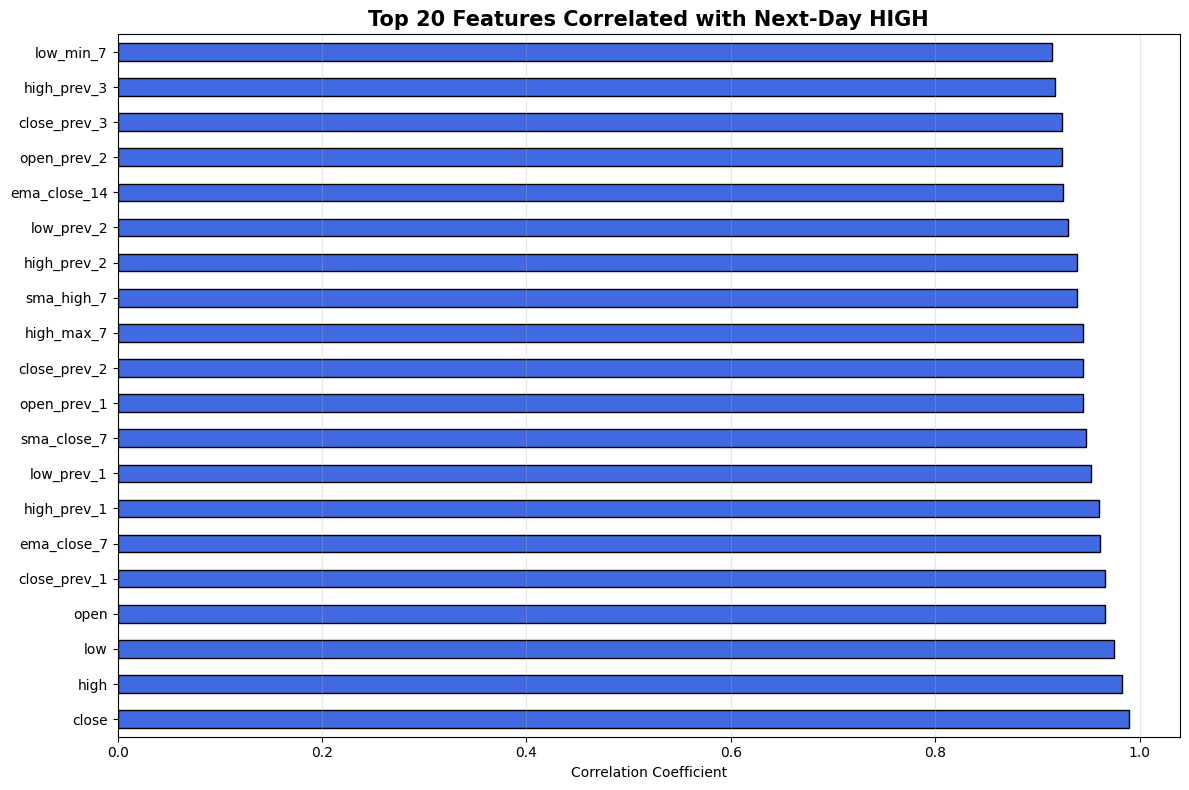


✓ As expected: recent highs, closes, and short-term lag features correlate most with the target.


In [37]:
# ============================================================
# 🔹 12. FEATURE CORRELATION ANALYSIS
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("CORRELATION ANALYSIS – TARGET VS FEATURES")
print("="*70)

# Only numeric columns
num_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'marketCap']
num_cols = [c for c in num_cols if c not in exclude_cols]

# Compute correlations
corr_series = clean_df[num_cols].corr()['target_high_tomorrow'].sort_values(ascending=False)

print("\nTop 30 features most correlated with next-day HIGH:")
print(corr_series.head(30))

print("\nBottom 10 features (least correlated):")
print(corr_series.tail(10))

# Visualization
top_corr = corr_series.head(21)[1:]  # Exclude target itself
plt.figure(figsize=(12, 8))
top_corr.plot(kind='barh', color='royalblue', edgecolor='black')
plt.title('Top 20 Features Correlated with Next-Day HIGH', fontsize=15, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ As expected: recent highs, closes, and short-term lag features correlate most with the target.")


In [38]:
# ============================================================
# 🔹 13. SAVE FINAL ENGINEERED DATASET
# ============================================================
import os

# Define Drive path
save_dir = '/content/drive/MyDrive/AdvMLAT3/processed'
os.makedirs(save_dir, exist_ok=True)

csv_path = os.path.join(save_dir, 'solana_features_engineered.csv')
parquet_path = os.path.join(save_dir, 'solana_features_engineered.parquet')
feature_txt_path = os.path.join(save_dir, 'feature_list.txt')

# Save datasets
clean_df.to_csv(csv_path, index=False)
clean_df.to_parquet(parquet_path, index=False)

print("\n" + "="*70)
print("✓ FINAL FEATURE ENGINEERING COMPLETE!")
print("="*70)
print(f"CSV file saved to: {csv_path}")
print(f"Parquet file saved to: {parquet_path}")
print(f"Final shape: {clean_df.shape}")
print(f"Date range: {clean_df['timestamp'].min().date()} → {clean_df['timestamp'].max().date()}")

# Save feature list summary
feature_list = [c for c in clean_df.columns if c not in base_columns]
with open(feature_txt_path, 'w') as f:
    f.write("Engineered Features for Solana\n")
    f.write("="*50 + "\n\n")
    for i, feature in enumerate(feature_list, 1):
        f.write(f"{i}. {feature}\n")

print(f"\nFeature list saved to: {feature_txt_path}")


✓ FINAL FEATURE ENGINEERING COMPLETE!
CSV file saved to: /content/drive/MyDrive/AdvMLAT3/processed/solana_features_engineered.csv
Parquet file saved to: /content/drive/MyDrive/AdvMLAT3/processed/solana_features_engineered.parquet
Final shape: (631, 126)
Date range: 2024-02-04 → 2025-10-26

Feature list saved to: /content/drive/MyDrive/AdvMLAT3/processed/feature_list.txt
